## Project2-Part2- SC, AL, NT



In [3]:
# This notebook contains general exploratory data analysis on the hate speech dataset. The data can be found here:  
# https://github.com/Vicomtech/hate-speech-dataset.git  

# The process used to collect, annotate, and model (classification) this dataset can be found in the following paper:  
# https://arxiv.org/pdf/1809.04444.pdf

In [4]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import numpy as np
import pandas as pd
from numpy import log, mean
from pandas import Series, DataFrame

from typing import List, Tuple, Union
import glob

from functional import seq
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import clear_output

From the original experimentation (https://arxiv.org/pdf/1809.04444.pdf) we'll use the same train and test split. 

In [5]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /home/chowdh83/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/chowdh83/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chowdh83/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/chowdh83/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [6]:
def readData(paths: List[str], group: str):
  
  pairs = []
  for p in paths:
    
    with open(p) as f:
      file_id = p.split('/')[-1].split('.')[0]
      pairs.append((file_id, f.read(), group))
  
  return pd.DataFrame(pairs, columns=["file_id", "text", "gSet"])

In [7]:
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

In [38]:
#trainDf testDf from hatespeech 
trainDf = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
testDf = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

trainDf = trainDf.join(idLabels.set_index('file_id'), on='file_id')
testDf = testDf.join(idLabels.set_index('file_id'), on='file_id')

#has both train and test
combDf = trainDf.append(testDf).reset_index(drop=True)

# print label distributions
print("Train dataset:")
print(trainDf['label'].value_counts(), "\n")
print("Test dataset:")
print(testDf['label'].value_counts(), "\n")

print("Total datase shape:")
print(combDf.shape)
combDf.head()

Train dataset:
hate      601
noHate    554
Name: label, dtype: int64 

Test dataset:
noHate    239
hate      239
Name: label, dtype: int64 

Total datase shape:
(1633, 4)


,file_id,text,gSet,label
0,12834217_2,In order to help increase the booklets downloa...,train,noHate
1,12834217_4,Click below for a FREE download of a colorfull...,train,hate
2,12834278_3,Click below for a FREE download of a colorfull...,train,hate
3,12834278_5,"Booklet updated on Dec. 9th , 2013 .",train,noHate
4,12834278_9,Thank you in advance. : ) Download the youtube...,train,noHate


We first extracted the following features to get a better understanding of the data by visualizing:
1. sentence length
2. word count
3. sentiment (polarity)
4. subjectivity

In [9]:
strSer = combDf['text'].str
txtBlob = combDf['text'].apply(lambda s: TextBlob(s))

combDf['sentence_len'] = strSer.len()
combDf['word_count'] = strSer.split().apply(lambda ls: len(ls))
combDf['polarity'] = txtBlob.apply(lambda blob: blob.sentiment.polarity)
combDf['subjectivity'] = txtBlob.apply(lambda blob: blob.sentiment.subjectivity)

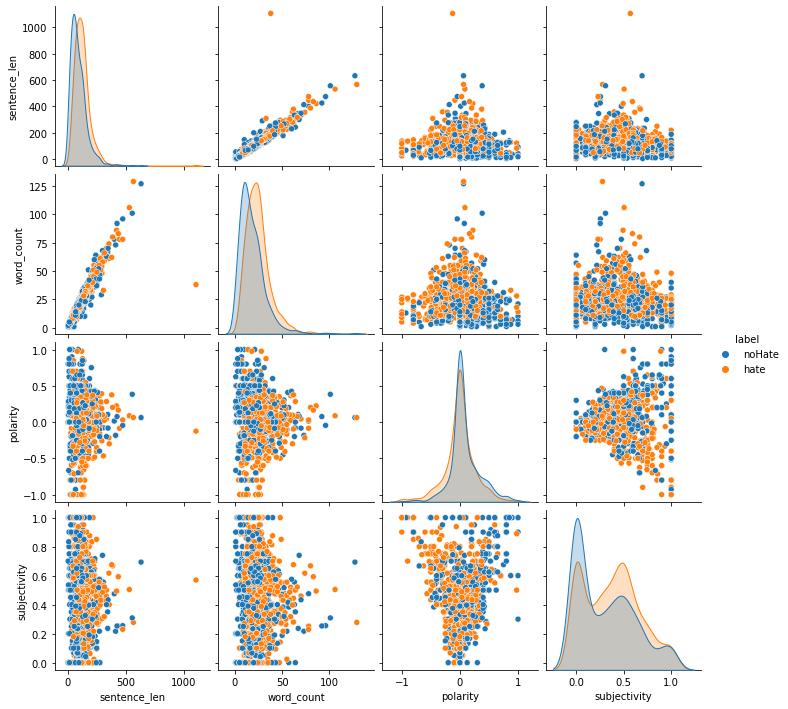

In [10]:
sns.pairplot(
  combDf[['sentence_len', 'word_count', 'polarity', 'subjectivity', 'label']], 
  hue="label"
)

We can see the distributions per category align well on top of each other. There is no discriminatory power in any of these metrics.

We can see the main target for these comments are blacks and jews with some minor mention of asians and muslims. This is expected given that data was gathered from a *white supremacist* forum. It might be interesting to quantify who are the primary targets of hate speech in different social media platforms. 

In [22]:
import spacy
from spacy.lang.en.examples import sentences 

# from sklearn.decomposition import LatentDirichletAllocation, NMF
# from sklearn.metrics import silhouette_score

In [23]:
nlp = spacy.load("en_core_web_sm")

In [24]:
def log_LhArr(src_arr: Series, ref_arr: Series):
  """
  Vectorized log-likelihood test.
  
  Parameters:
  -----------
  - src_arr: sum of tokens across all documents in the source group. Shape (1, n)
  - ref_arr: sum of tokens across all documents in the reference group. Shape (1, n)
  
  Order in which parameters are passed does not affect the results.
  """
  src_count: int = src_arr.sum()
  ref_count: int = ref_arr.sum()
  
  agg = (src_arr + ref_arr) / (src_count + ref_count)
  e1 = src_count * agg
  e2 = ref_count * agg
  
  p1 = src_arr * log(src_arr / e1)
  p2 = ref_arr * log(ref_arr / e2)

  return 2 * (p1 + p2)
  
  
def topWordsByLogLikelihood(
  docWordMatrix: DataFrame, 
  labels: List[str], 
  topN: int) -> Tuple[Series, Series]:
  """
  Prints top words sorted by log likelihood test. 
  Assumes matrix is binary (only 2 labels).
  """
  label1, label2 = set(labels)
  
  aggDf = docWordMatrix.assign(label=labels).groupby('label').sum().T
  
  aggDf = aggDf.assign(
    # difference between token counts in both categories.
    # needed to separate key tokens in each category. 
    l1Diff = aggDf[label1] - aggDf[label2], 
    l2Diff = aggDf[label2] - aggDf[label1],
    # likelihood of all tokens
    # is the likelihood of observing 'this' token in group A significantly different from B
    llikelihood = log_LhArr(aggDf[label1].replace(0, 0.01), aggDf[label2].replace(0, 0.01))
  )
  
  # boolean masks to select tokens in each category
  label1_i = aggDf['l1Diff'] > 0
  label2_i = aggDf['l1Diff'] < 0
  
  l1 = aggDf[label1_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  l2 = aggDf[label2_i].sort_values(by='llikelihood', ascending=False)[:topN]['llikelihood']
  
  print(f"\nTop {label1.upper()} tokens by likelihood:\n")
  print(l1)

  print(f"\nTop {label2.upper()} tokens by likelihood:\n")
  print(l2)
  
  return (l1, l2)

In [25]:
def hateTokenizer(text: str, spacyModel=nlp):
  """
  Simple tokenizer to:
    - extract alphabetical tokens
    - remove stopwords
    - lemmatize and lowercase tokens 
  """
  doc = spacyModel(text)
  
  return seq(token for token in doc)\
    .filter(lambda t: t.is_alpha)\
    .filter_not(lambda t: t.is_stop)\
    .map(lambda t: t.lemma_.lower())\
    .to_list()

In [28]:
def rawCorpusToDf(
  corpus: Union[List[str], Series], 
  tokenizer=hateTokenizer, 
  idf=False) -> DataFrame:
  """Tokenize corpus and build doc-term matrix."""
  vectorizer = (
    TfidfVectorizer(tokenizer=tokenizer, lowercase=False) 
    if idf else
    CountVectorizer(tokenizer=tokenizer, lowercase=False)
  )

  X = vectorizer.fit_transform(corpus)

  return pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())



In [29]:
count_df = rawCorpusToDf(combDf['text'])
l1, l2 = topWordsByLogLikelihood(count_df, combDf['label'].tolist(), 10)


Top HATE tokens by likelihood:

black    44.709483
jews     37.334256
negro    25.396914
ape      23.801547
race     23.410760
scum     22.269892
non      17.626058
groid    17.557590
jew      15.704856
mud      14.436472
Name: llikelihood, dtype: float64

Top NOHATE tokens by likelihood:

post       22.241187
youtube    20.193442
year       15.207984
pm         13.989821
thread     13.741175
talk       12.447087
meet       11.653780
site       11.653780
info       10.766367
teacher    10.753152
Name: llikelihood, dtype: float64


In [30]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score

In [31]:
models = list()

for n in range(2, 9):
  lda = LatentDirichletAllocation(n_components=n, random_state=0)
  lda.fit(count_df)
  models.append((n, lda))

In [32]:
def topWords(
  componentsMatrix: Union[DataFrame, np.ndarray],
  words: List[str]=count_df.columns.tolist(),
  topN: int=10) -> None:
  """
  Print top keywords by each component in componentsMatrix.
  
  Parameters:
  -----------
  - componentsMatrix: components matrix from factorization. Shape: (n_topics, tokens_len).
  - words: list with words/tokens. Usually the columns of the document-word matrix.
      Length must be equal to *tokens_len* (see parameter above).
  - topN: number of words to print per topic.
  """
  df = pd.DataFrame(componentsMatrix.T, index=words)
  cols = [f"topic-{t}" for t in df.columns]
  
  finalDf = pd.DataFrame([
    df.sort_values(by=col, ascending=False)[:topN].index
    for col in df.columns
  ]).T
  
  print(finalDf.set_axis(cols, axis=1))

In [33]:
for n, model in models:
  if n > 5:
    break
    
  print("\n", f"Top Keywords With {n} Topics:", "\n")
  topWords(model.components_)


 Top Keywords With 2 Topics: 

   topic-0 topic-1
0    black   white
1    white    like
2   people    race
3     time  people
4     good      go
5    negro     not
6     come    year
7      way   think
8  country    look
9      day    want

 Top Keywords With 3 Topics: 

   topic-0 topic-1  topic-2
0    white   white    black
1    negro    like    white
2     time    race   people
3     tell      go     like
4     come     not    think
5  country    know     year
6   people  people     good
7      day     kid    start
8    black    want  ireland
9     know    look      get

 Top Keywords With 4 Topics: 

  topic-0 topic-1 topic-2  topic-3
0   white   white   black     like
1    time    race   white  country
2    know    like  people   people
3   negro      go    like    negro
4    come     not    year  ireland
5    like   woman    good     tell
6  people  people    hate      try
7     day     non     not      kid
8   thank    know   think      get
9   think   think     way    black

 

In [34]:
hateText = combDf[combDf['label'] == 'hate']['text'].str.lower()
docs = list(nlp.pipe(hateText, disable=["ner", "textcat"]))

In [35]:
# possible dependency tags
# dobj, nsubj, nsubjpass

nouns = set([token.lemma_ 
  for doc in docs
  for token in doc
  if token.dep_ == 'nsubj' and not token.is_stop and len(token) > 2
])

pairs = [(hateText.str.contains(nn).sum(), nn) for nn in nouns]
targetsDf = pd.DataFrame(pairs, columns=["sentence_count", "target"])

In [36]:
def cleanDfText(df, col_remove='target', col_sort='sentence_count', show=20):
  """
  Utility function to remove words from a column, 1 by 1. Function asks user 
  what word to remove, the new dataframe without the word is printed and the loop repeats.
  
  Parameters:
  -----------
  - df: Pandas Dataframe.
  - col_remove: the column with possible words to remove.
  - col_sort: numerical column to sort by after each loop.
  - show: dataframe number of items to display after each loop.
  """
  newDf = df.copy()
  removed = list()
  
  while True:
    word = input("Word to remove (enter 'q' to exit):")
    
    if word == 'q':
      return removed, newDf
      
    newDf = newDf[newDf[col_remove] != word]\
              .sort_values(by=col_sort, ascending=False)\
              .reset_index(drop=True)
    
    removed.append(word)
    clear_output(wait=True)
    print(newDf.head(show))
    
    # clear Jupyter notebook input/output
    In.clear()
    Out.clear()

In [37]:
toRemove = ['er','lack','one','use','man','ted','people','way','race',
 'red','cause','non','ape','rat','time','son','country','don','thing',
 'school','world','child','hate','work','kid','lie','nation','scum','hell','mud',
 'filth','human','sex','house','being','car','arm','place','crime','guy',
 'crap','breed','news','town','male'
]

targetsDf[~targetsDf['target'].str.contains("|".join(toRemove))]\
  .sort_values(by="sentence_count", ascending=False)\
  .reset_index(drop=True).head(15)

,sentence_count,target
0,396,ing
1,200,white
2,74,jew
3,70,negro
4,39,let
5,37,africa
6,33,jews
7,31,good
8,26,nig
9,25,ireland


In [40]:
#now we will attempt to use bert to do a binary classification of the dataset

In [65]:
import pkg_resources
import subprocess
import pickle
import shutil
import time
import sys
import os

from enum import Enum
from functools import partial

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'transformers'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from typing import List, Dict, Tuple
import glob

from dataclasses import dataclass

from sklearn.metrics import accuracy_score

from torch import torch
from torch.utils.data import Dataset
from torch import nn

import numpy as np
import pandas as pd
from pandas import DataFrame

from transformers import PreTrainedTokenizer, PreTrainedModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import DistilBertModel, DistilBertPreTrainedModel
from transformers import Trainer, TrainingArguments
from transformers import EvalPrediction

In [66]:
def readData(paths: List[str], group: str):
  pairs = []
  for p in paths:
    
    with open(p) as f:
      file_id = p.split('/')[-1].split('.')[0]
      pairs.append((file_id, f.read(), group))
  
  return pd.DataFrame(pairs, columns=["file_id", "text", "gSet"])

idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

trainDf = readData(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
testDf = readData(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

trainDf = trainDf.join(idLabels.set_index('file_id'), on='file_id')
testDf = testDf.join(idLabels.set_index('file_id'), on='file_id')

print(trainDf.info(), '\n')
print(testDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  1155 non-null   object
 1   text     1155 non-null   object
 2   gSet     1155 non-null   object
 3   label    1155 non-null   object
dtypes: object(4)
memory usage: 36.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  478 non-null    object
 1   text     478 non-null    object
 2   gSet     478 non-null    object
 3   label    478 non-null    object
dtypes: object(4)
memory usage: 15.1+ KB
None


In [67]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# save original model set of weights. They we'll be used later over multiple iterations
torch.save(model.state_dict(), "./tempBertState.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

In [84]:


class Triple:
  """
  Class for keeping track of single tokenized inputs 
  (for Pytorch Dataset __getitem__).
  """
  inputs: List[int]
  masks: List[int]
  label: int
  
  def triple(self):
    return (self.inputs, self.masks, self.label)

  
class HateDataset(Dataset):
  """PyTorch Dataset class. Required as Trainer input."""
  def __init__(self, 
    corpus: List[str], labels: List[str], 
    tokenizer: PreTrainedTokenizer=tokenizer,
    truncate=True,
    padding=True
  ):
    self.tokenizer = tokenizer
    self.trunc = truncate
    # corpus is entirely tokenized during instantiation
    self.corpusTokenized = tokenizer(corpus, padding=padding)
    self.labels = labels
    
  
  def __getitem__(self, i):
    inputs = self.corpusTokenized['input_ids'][i]
    masks = self.corpusTokenized['attention_mask'][i]
    
    return Triple(
      self._truncate(inputs) if self.trunc else inputs,
      self._truncate(masks, is_mask=True) if self.trunc else masks,
      self.labels[i]
    )
  
  def __len__(self):
    return len(self.labels)
  
  def _truncate(self, vector: List[int], is_mask=False, sep_token_num=102):
    """
    Truncate vector length to model max input size (the default transformers 
    library implementation does not seem to work with batches!).
    """
    limit = self.tokenizer.model_max_length
    
    if len(vector) <= limit:
      return vector
    elif is_mask:
      return vector[:limit]
    else:
      last = sep_token_num if vector[-1] not in (0, sep_token_num) else 0
      return vector[:limit - 1] + [last]
  
  
def collator(items: List[Triple]) -> Dict:
  """
  Collects list of items into a single dictionary; this dictionary's keys/values match 
  the parameter names and format of the model selected. This function is used by the 
  Pytorch Dataloader inside the Trainer class.
  """
  # keys for DistilBertForSequenceClassification
  input_k = 'input_ids'
  mask_k = 'attention_mask'
  label_k = 'labels'
  
  # zipps all input_ids, attention_mask and labels together
  zipped =  list(map(list, zip(*[t.triple() for t in items])))
  # convert lists to pytorch tensors
  inputs, masks, labels = list(map(lambda ls: torch.tensor(ls), zipped))
  
  return {input_k: inputs, mask_k: masks, label_k: labels}


def prepareDf(df: DataFrame, textCol='text', labelsCol='label'):
  """Extract relevant columns to be fed to a Dataset object."""
  return {
    "corpus": df[textCol].tolist(),
    "labels": df[labelsCol].map({'hate': 1, 'noHate': 0})
  }


def hateMetrics(pred: EvalPrediction):
  """
  Compute 3 accuracies: all labels, hate, noHate. These are the baseline metrics 
  used in the paper to compare models (https://arxiv.org/pdf/1809.04444.pdf, page 7).
  Function assumes 'hate' group uses label 1, 'noHate' uses label 0.
  
  For reference, results from paper:

      Accu | hate | noHate | all
      ---------------------------
      SVM  | 0.69 | 0.73   | 0.71
      CNN  | 0.55 | 0.79   | 0.66
      LSTM | 0.71 | 0.75   | 0.73
  """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  mapper = lambda n: True if n == 1 else False

  hatePreds = preds[[mapper(l) for l in labels]]
  noHatePreds = preds[[mapper(l) for l in 1 - labels]]

  return {
      'accHate': accuracy_score(hatePreds, np.ones_like(hatePreds)),
      'accNoHate': accuracy_score(noHatePreds, np.zeros_like(noHatePreds)),
      'accAll': accuracy_score(labels, preds),
  }

In [85]:
train_dataset = HateDataset(**prepareDf(trainDf))
test_dataset = HateDataset(**prepareDf(testDf))

# for testing purposes
train_ds_mock = HateDataset(**prepareDf(trainDf[:20]))
test_ds_mock = HateDataset(**prepareDf(testDf[:20]))

In [89]:
# Trainer and TrainingArguments are both classes from transformers to facilitate training.

def trainingArgs(epochs, trainDir, batchSizeTrain=16, batchSizeEval=32,training_set_len=len(train_dataset)):
      """Return a TrainingArguments instance to be passed to Trainer class."""
      # calculate total training steps 
      totalSteps = int((training_set_len / batchSizeTrain) * epochs)
      # use 5% of all training steps as warmup
      warmup = int(totalSteps * 0.05)
     
      
      return TrainingArguments(output_dir=f"./{trainDir}/results", logging_dir=f"./{trainDir}/logs",

        overwrite_output_dir=True,
        # trains faster without evaluation
        #evaluate_during_training=False,

        per_device_train_batch_size=batchSizeTrain,   
        per_device_eval_batch_size=batchSizeEval, 

        num_train_epochs=epochs,
        warmup_steps=warmup,   

        # I won't be logging or checkpointing since 
        # training occurs fairly quickly
        logging_steps=9999,
        save_steps=9999,
        save_total_limit=1,

        # standard arguments
        learning_rate=5e-5,
        weight_decay=1e-2,
      )

In [90]:
# training arguments 
tDir = "training"
saveModelDir = "tuned-bert"
epochsList = [2, 3, 4]

embArgs= trainingArgs(2, trainDir = tDir)
trainDs = train_dataset
testDs = test_dataset

# uncomment these to pass arguments for testing purposes
# epochsList = [2]
# embArgs = trainingArgs(2, trainDir, 2, 4, len(train_ds_mock))
# trainDs = train_ds_mock
# testDs = test_ds_mock

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [95]:
from pathlib import Path

def rmdir(directory):
    directory = Path(directory)
    for item in directory.iterdir():
        if item.is_dir():
            rmdir(item)
        else:
            item.unlink()
    directory.rmdir()

# rmdir(Path("dir/"))

In [98]:
finalMetrics = list()

for epoch in epochsList:
  # start each iteration with the original set of weights
  model.load_state_dict(torch.load("./tempBertState.pt"))
  
  embArgs.num_train_epochs = epoch
  
  trainer = Trainer(
    model=model,                         
    args=embArgs,   
    data_collator=collator,
    
    train_dataset=trainDs,         
    eval_dataset=testDs,
    compute_metrics=hateMetrics
  )

  trainer.train()
  evaMetrics: Dict = trainer.evaluate()
  trainLoss: float = trainer.evaluate(trainDs)['eval_loss']
  
  finalMetrics.append(
    {"epoch": epoch, "eval_train_loss": trainLoss, **evaMetrics}
  )

  trainer.save_model(f"./{saveModelDir}/epoch-{epoch}")
  
  # clean logs
#   shutil.rmtree(f"./{trainDir}")

/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 146


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-2
Configuration saved in ./tuned-bert/epoch-2/config.json
Model weights saved in ./tuned-bert/epoch-2/pytorch_model.bin
/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 219


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-3
Configuration saved in ./tuned-bert/epoch-3/config.json
Model weights saved in ./tuned-bert/epoch-3/pytorch_model.bin
/home/chowdh83/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1155
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 292


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 478
  Batch size = 32


***** Running Evaluation *****
  Num examples = 1155
  Batch size = 32
Saving model checkpoint to ./tuned-bert/epoch-4
Configuration saved in ./tuned-bert/epoch-4/config.json
Model weights saved in ./tuned-bert/epoch-4/pytorch_model.bin


In [100]:
metricsTunedDf = pd.DataFrame(finalMetrics)
metricsTunedDf

,epoch,eval_train_loss,eval_loss,eval_accHate,eval_accNoHate,eval_accAll,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,2.0,0.155936,0.474759,0.811715,0.824268,0.817992,25.3824,18.832,0.591
1,3.0,0.063797,0.577032,0.836820,0.799163,0.817992,23.9556,19.954,0.626
2,4.0,0.025063,0.717186,0.836820,0.769874,0.803347,24.8476,19.237,0.604
